# Evaluaremos los resultados de los modelos

In [19]:
# Importamos las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import time
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import copy

import warnings
warnings.filterwarnings("ignore")

from pycaret.datasets import get_data
from pycaret.classification import *

import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib widget

In [20]:
# Cargamos la base de datos
Base = pd.read_csv("Base.csv")

Base['Time'] = pd.to_datetime(Base['Time'])
Base.set_index('Time',inplace=True)

Base

,Block Height,Hook Load,WOB,Torque,Flow In,Pump Pressure,RPM,ROP,Evento,Pega,Actividad
Time,,,,,,,,,,,
2015-02-01 00:00:57,57.708860,430.624454,1.301011,1.016953,357.482920,2022.031010,68.507219,0.0,Evento 1,0,RIH
2015-02-01 00:01:00,55.942886,429.602631,1.165243,0.680712,360.418803,2058.592517,60.428979,0.0,Evento 1,0,RIH
2015-02-01 00:01:03,54.164406,428.439948,0.942667,0.394440,365.651801,2097.301313,52.715292,0.0,Evento 1,0,RIH
2015-02-01 00:01:06,52.383372,428.350848,0.769924,0.365904,366.095786,2096.310389,46.199610,0.0,Evento 1,0,RIH
2015-02-01 00:01:09,50.617904,428.265523,0.516112,0.341655,366.543219,2127.829605,39.726500,0.0,Evento 1,0,RIH
...,...,...,...,...,...,...,...,...,...,...,...
2014-04-23 17:01:33,49.594614,306.238681,6.478149,4.480541,72.917473,1455.683618,89.093420,0.0,Evento 16,1,RIH
2014-04-23 17:01:36,49.594614,306.238681,6.478149,4.480541,72.917473,1455.683618,89.093420,0.0,Evento 16,1,RIH
2014-04-23 17:01:39,49.614314,306.256665,6.008588,4.371957,67.291780,1382.719355,87.606353,0.0,Evento 16,1,RIH


# Cargamos los modelos

In [21]:
# Cat Boost Classifier
Model_CBC = load_model('CBC_Model')

# Isolation Forest
Model_iForest = load_model('iforest_Model')

# NN LSTM
Model_LSTM = keras.models.load_model('LSTM_Model.h5')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


# Definimos la funcion de graficación de resultados

In [42]:
# Funcion de creacion de dataset para red LSTM
def generate_data(X, y, sequence_length, step,longitud):
    X_local = []
    y_local = []
    for start in range(0, longitud - sequence_length, step):
        end = start + sequence_length
        X_local.append(X[start:end])
        y_local.append(y[end-1])
    return np.array(X_local), np.array(y_local)

In [23]:
Base

,Block Height,Hook Load,WOB,Torque,Flow In,Pump Pressure,RPM,ROP,Evento,Pega,Actividad
Time,,,,,,,,,,,
2015-02-01 00:00:57,57.708860,430.624454,1.301011,1.016953,357.482920,2022.031010,68.507219,0.0,Evento 1,0,RIH
2015-02-01 00:01:00,55.942886,429.602631,1.165243,0.680712,360.418803,2058.592517,60.428979,0.0,Evento 1,0,RIH
2015-02-01 00:01:03,54.164406,428.439948,0.942667,0.394440,365.651801,2097.301313,52.715292,0.0,Evento 1,0,RIH
2015-02-01 00:01:06,52.383372,428.350848,0.769924,0.365904,366.095786,2096.310389,46.199610,0.0,Evento 1,0,RIH
2015-02-01 00:01:09,50.617904,428.265523,0.516112,0.341655,366.543219,2127.829605,39.726500,0.0,Evento 1,0,RIH


In [92]:
# Funcion de prediccion de red LSTM
def pred_LSTM(Base,Modelo,Evento):
    '''
    Función que produce la prediccion de una red LSTM
    '''
    df = copy.deepcopy(Base)

    # Codificamos variables categoricas
    encoder = LabelEncoder()
    df["Actividad"] = encoder.fit_transform(df["Actividad"])
    df["Evento"] = encoder.fit_transform(df["Evento"])
    
    id_evento = np.where(encoder.classes_==Evento)[0][0]

    # Filtramos el evento
    df = df.loc[df.Evento==id_evento]

    #Transormamos el dataset para usar 10 minutos de historia en cada punto
    X_sequence, y = generate_data(df.drop(columns=["Pega"]).values, df.Pega,20*10,1,len(df))

    # Realizamos la predicción con el modelo
    y_prob = Modelo.predict(X_sequence, verbose=1)

    # Discriminamos las predicciones
    y_pred = np.where(y_prob > 0.5, 1, 0)

    df = df[200:]

    df["Label"] = y_pred

    return df

In [93]:
test = pred_LSTM(Base,Model_LSTM,"Evento 2")

383/383 [==============================] - 13s 34ms/step


In [94]:
test

,Block Height,Hook Load,WOB,Torque,Flow In,Pump Pressure,RPM,ROP,Evento,Pega,Actividad,Label
Time,,,,,,,,,,,,
2015-01-15 00:10:57,30.687093,450.682766,13.106522,9.324944,314.456405,2610.537328,437.987628,0.185584,8,0,0,0
2015-01-15 00:11:00,30.687093,450.688186,13.131893,9.328985,314.456405,2610.046986,437.979700,0.185385,8,0,0,0
2015-01-15 00:11:03,30.687093,450.689006,13.140066,9.332245,314.456405,2610.234930,437.952313,0.186255,8,0,0,0
2015-01-15 00:11:06,30.687093,450.687428,13.132887,9.334673,314.456405,2610.009638,437.848171,0.186056,8,0,0,0
2015-01-15 00:11:09,30.687093,450.686167,13.127250,9.335749,314.456405,2609.838561,437.885648,0.196488,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-15 10:23:24,30.687093,448.346326,11.379283,9.377378,311.932074,2642.999880,452.994895,0.000215,8,1,0,1
2015-01-15 10:23:27,30.687093,448.346325,11.379283,9.382750,311.932078,2642.708325,452.994895,0.000215,8,1,0,1
2015-01-15 10:23:30,30.687093,448.346325,11.379283,9.387124,311.932081,2648.764708,452.966427,0.000000,8,1,0,1


In [100]:
def plot_results_stuck(Evento,Model_1,Model_2,Model_3,df,size):
    
    '''
    Funcion que toma tres modelos, una base de datos y realiza la comparacion de las predicciones de eventos de stuck pipe
    '''

    # Filtramos el evento
    Base = df
    df = df.loc[df.Evento==Evento]

    # Realizamos las tres predicciones de los modelo
    
    Pred_1  = predict_model(Model_1, data = df,probability_threshold = 0.4026 )
    Pred_2 = predict_model(Model_iForest, data = df)
    Pred_3 = pred_LSTM(Base,Model_3,Evento)

    #Pred_3 = np.where(Model_3.predict(df, verbose=1) > 0.5, 1, 0)

    fig2, ax2 = plt.subplots(nrows=1, ncols=6, figsize=(12,size), sharey=True)
    fig2.suptitle(Evento, fontsize=20,va="top")
    fig2.subplots_adjust(top=0.8,wspace=0.25)
 
    #1st track: Block Height, Hook Load & ROP
    ax01=ax2[0].twiny()
    ax01.invert_xaxis()
    ax01.invert_yaxis()
    ax01.set_xlim(0,120)
    ax01.set_ylim([np.max(df.index), np.min(df.index)])
    ax01.spines['top'].set_position(('outward',0))
    ax01.set_xlabel("Block Height [ft]")
    ax01.plot(df["Block Height"], df.index,"--", label='Block Height [ft]', color='red')
    ax01.set_xlabel('Block Height [ft]',color='red')    
    ax01.tick_params(axis='x', colors='red')
    
    ax11=ax2[0].twiny()
    ax11.invert_xaxis()
    ax11.invert_yaxis()
    ax11.set_xlim(0,900)
    ax11.plot(df["Hook Load"], df.index, label='Hook Load [Klb]', color='blue') 
    ax11.spines['top'].set_position(('outward',40))
    ax11.set_xlabel('Hook Load [Klb]',color='blue')    
    ax11.tick_params(axis='x', colors='blue')

    ax21=ax2[0].twiny() 
    ax21.invert_xaxis()
    ax21.invert_yaxis()
    ax21.invert_yaxis()
    ax21.set_xlim(0,150)
    ax21.plot(df["ROP"], df.index, label='ROP[ft/hr]', color='magenta') 
    ax21.spines['top'].set_position(('outward',80))
    ax21.set_xlabel('ROP[ft/hr]',color='magenta')    
    ax21.tick_params(axis='x', colors='magenta')
    ax21.grid(True)
    
    #2nd track: WOB, Torque, RPM
    ax02=ax2[1].twiny()
    ax02.invert_xaxis()
    ax02.invert_yaxis()
    ax02.set_xlim(0,90)
    ax02.spines['top'].set_position(('outward',0))
    ax02.set_xlabel('WOB[KLb]', color='lime')
    ax02.plot(df.WOB, df.index,"--", label='WOB[KLb]', color='lime')
    ax02.tick_params(axis='x', colors='lime')    
    ax02.grid(True)
    
    ax12=ax2[1].twiny()
    ax12.invert_xaxis()
    ax12.invert_yaxis()
    ax12.set_xlim(0,36)
    ax12.plot(df.Torque, df.index,":", label='Torque[KLb-ft]', color='blue') 
    ax12.spines['top'].set_position(('outward',40))
    ax12.set_xlabel('Torque[KLb-ft]', color='blue')    
    ax12.tick_params(axis='x', colors='blue')
    
    ax22=ax2[1].twiny()
    ax22.invert_xaxis()
    ax22.invert_yaxis()
    ax22.set_xlim(0,180)
    ax22.plot(df["RPM"], df.index, '-',label='RPM[Rev/min]', color='dimgrey') 
    ax22.spines['top'].set_position(('outward',80))
    ax22.set_xlabel('RPM[Rev/min]',color='dimgrey')
    ax22.tick_params(axis='x', colors='dimgrey')

    #3rd track: Flow In & Pump Pressure
    ax03=ax2[2].twiny()
    ax03.invert_xaxis()
    ax03.invert_yaxis()
    ax03.set_xlim(0,1200)
    ax03.spines['top'].set_position(('outward',0))
    ax03.set_xlabel('Flow In[GPM]')
    ax03.plot(df["Flow In"], df.index,'--', label='DT[us/ft]', color='red')
    ax03.set_xlabel('Flow In[GPM]', color='red')    
    ax03.tick_params(axis='x', colors='red')
    ax03.grid(True)
    
    ax13=ax2[2].twiny()
    ax13.invert_xaxis()
    ax13.invert_yaxis()
    ax13.set_xlim(0,6000)
    ax13.plot(df["Pump Pressure"], df.index, label='Pump Pressure[psi]', color='blue') 
    ax13.spines['top'].set_position(('outward',40))
    ax13.set_xlabel('Pump Pressure[psi]', color='blue')    
    ax13.tick_params(axis='x', colors='blue')
    
    #4rd track: Preicciones Modelo CBC
    ax04=ax2[3].twiny()
    ax04.invert_xaxis()
    ax04.invert_yaxis()
    ax04.set_xlim(0,1)
    ax04.spines['top'].set_position(('outward',0))
    ax04.set_xlabel('Stuck Pipe')
    ax04.fill_between(Pred_1.Pega, Pred_1.index, label="Tuberia Libre o Pegada", color='blue') 
    ax04.set_xlabel('Libre [0] - Pegado [1]', color='blue')
    ax04.tick_params(axis='x', colors='blue')
    ax04.grid(True)
    
    ax14=ax2[3].twiny()
    ax14.invert_xaxis()
    ax14.invert_yaxis()
    ax14.set_xlim(0,1)
    ax14.plot(Pred_1["Label"], Pred_1.index,label="Prediccion Pega", color='red') 
    ax14.spines['top'].set_position(('outward',40))
    ax14.set_xlabel('Pump Pressure[psi]', color='blue')   
    ax14.set_xlabel('Prediccion Pega', color='red')     
    ax14.tick_params(axis='x', colors='red')

    ax14.title.set_text('CatBoost')
    
    #5rd track:  Preicciones Modelo iForest
    ax05=ax2[4].twiny()
    ax05.invert_xaxis()
    ax05.invert_yaxis()
    ax05.set_xlim(0,1)
    ax05.spines['top'].set_position(('outward',0))
    ax05.set_xlabel('Stuck Pipe')
    ax05.fill_between(Pred_2.Pega, Pred_2.index, label="Tuberia Libre o Pegada", color='blue') 
    ax05.set_xlabel('Libre [0] - Pegado [1]', color='blue')    
    ax05.tick_params(axis='x', colors='blue')
    ax05.grid(True)
    
    ax15=ax2[4].twiny()
    ax15.invert_xaxis()
    ax15.invert_yaxis()
    ax15.set_xlim(0,1)
    ax15.plot(Pred_2["Label"], Pred_2.index,label="Prediccion Pega", color='red')
    ax15.spines['top'].set_position(('outward',40))
    ax15.set_xlabel('Prediccion Pega', color='red')    
    ax15.tick_params(axis='x', colors='red')

    ax15.title.set_text('Isolation Forest')

    #6rd track:  Preicciones Modelo iForest
    ax06=ax2[5].twiny()
    ax06.invert_xaxis()
    ax06.invert_yaxis()
    ax06.set_xlim(0,1)
    ax06.spines['top'].set_position(('outward',0))
    ax06.set_xlabel('Stuck Pipe')
    ax06.fill_between(Pred_3.Pega, Pred_3.index, label="Tuberia Libre o Pegada", color='blue') 
    ax06.set_xlabel('Libre [0] - Pegado [1]', color='blue')    
    ax06.tick_params(axis='x', colors='blue')
    ax06.grid(True)
    
    ax16=ax2[5].twiny()
    ax16.invert_xaxis()
    ax16.invert_yaxis()
    ax16.set_xlim(0,1)
    ax16.plot(Pred_3["Label"], Pred_3.index,label="Prediccion Pega", color='red')
    ax16.spines['top'].set_position(('outward',40))
    ax16.set_xlabel('Prediccion Pega', color='red')    
    ax16.tick_params(axis='x', colors='red')

    ax16.title.set_text('LSTM')


410/410 [==============================] - 16s 39ms/step


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
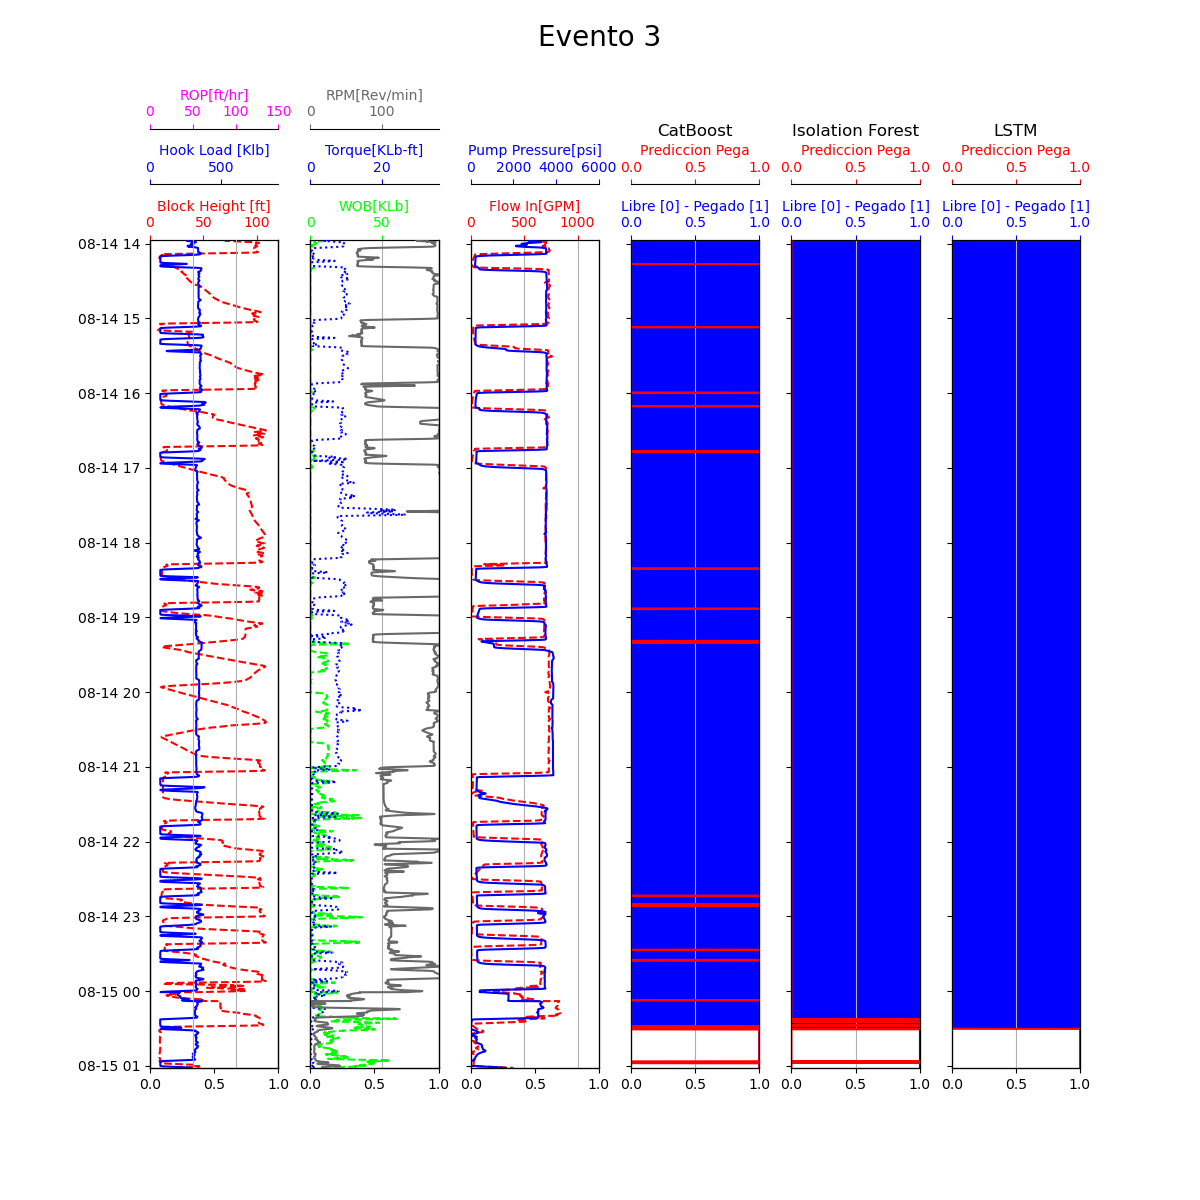

In [104]:
plot_results_stuck("Evento 3",Model_CBC,Model_iForest,Model_LSTM,Base,12)